In [5]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


In [6]:
df = pd.read_csv('datasets/user_behavior_dataset.csv')

In [7]:
df.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    object 
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    object 
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 60.3+ KB


In [11]:
df.isna().sum()

User ID                       0
Device Model                  0
Operating System              0
App Usage Time (min/day)      0
Screen On Time (hours/day)    0
Battery Drain (mAh/day)       0
Number of Apps Installed      0
Data Usage (MB/day)           0
Age                           0
Gender                        0
User Behavior Class           0
dtype: int64

#### Подготовка данных

In [12]:
def series_to_map_dict(ser):
    res_dict = {}

    val_arr = ser.unique()
    for num, val in zip(range(len(val_arr)), val_arr):
        res_dict[val] = num
    
    return res_dict

In [22]:
df_mapped = df.copy()

df_mapped = df_mapped.drop(['User ID'], axis=1)

model_map = series_to_map_dict(df_mapped['Device Model'])
df_mapped['Device Model'] = df_mapped['Device Model'].map(model_map)

os_map = series_to_map_dict(df_mapped['Operating System'])
df_mapped['Operating System'] = df_mapped['Operating System'].map(os_map)

gender_map = series_to_map_dict(df_mapped['Gender'])
df_mapped['Gender'] = df_mapped['Gender'].map(gender_map)

ubc_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
df_mapped['User Behavior Class'] = df_mapped['User Behavior Class'].map(ubc_map)

df_mapped.head()

,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,0,0,393,6.4,1872,67,1122,40,0,3
1,1,0,268,4.7,1331,42,944,47,1,2
2,2,0,154,4.0,761,32,322,42,0,1
3,0,0,239,4.8,1676,56,871,20,0,2
4,3,1,187,4.3,1367,58,988,31,1,2


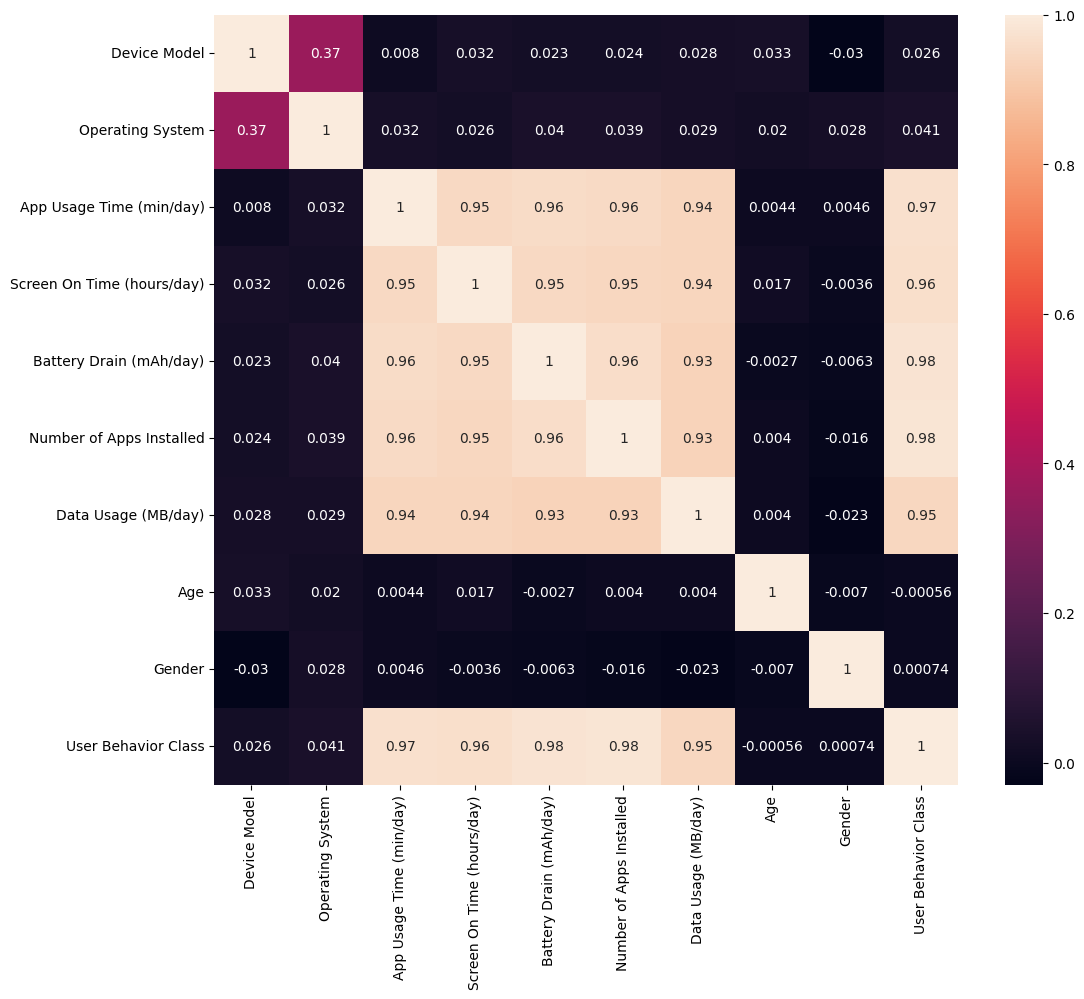

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(df_mapped.corr(numeric_only = True), annot=True)
plt.show()

In [24]:
df_mapped['User Behavior Class'].value_counts()

User Behavior Class
1    146
2    143
3    139
4    136
0    136
Name: count, dtype: int64

In [37]:
df_balanced = df_mapped.groupby('User Behavior Class').apply(lambda x: x.sample(df_mapped['User Behavior Class'].value_counts().min())).reset_index(drop=True)
df_balanced['User Behavior Class'].value_counts()

C:\Temp\ipykernel_16776\3877097515.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_mapped.groupby('User Behavior Class').apply(lambda x: x.sample(df_mapped['User Behavior Class'].value_counts().min())).reset_index(drop=True)


User Behavior Class
0    136
1    136
2    136
3    136
4    136
Name: count, dtype: int64

In [39]:
X_orig = df_balanced.drop(['User Behavior Class'], axis=1)
y_orig = df_balanced['User Behavior Class']
print(f'X shape: {X_orig.shape} | y shape: {y_orig.shape} ')

X shape: (680, 9) | y shape: (680,) 


In [46]:
X_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Device Model                680 non-null    int64  
 1   Operating System            680 non-null    int64  
 2   App Usage Time (min/day)    680 non-null    int64  
 3   Screen On Time (hours/day)  680 non-null    float64
 4   Battery Drain (mAh/day)     680 non-null    int64  
 5   Number of Apps Installed    680 non-null    int64  
 6   Data Usage (MB/day)         680 non-null    int64  
 7   Age                         680 non-null    int64  
 8   Gender                      680 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 47.9 KB


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.20, shuffle=True, random_state=15, stratify=y_orig)

In [50]:
X = X_train.values
y = y_train.values
feature_names = X_train.columns.tolist()# имена столбцов в data.
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                                        criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_ #это оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели.
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,
                                "VARIABLE":feature_names}).sort_values("IMPORTANCE",
                                                                       ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")

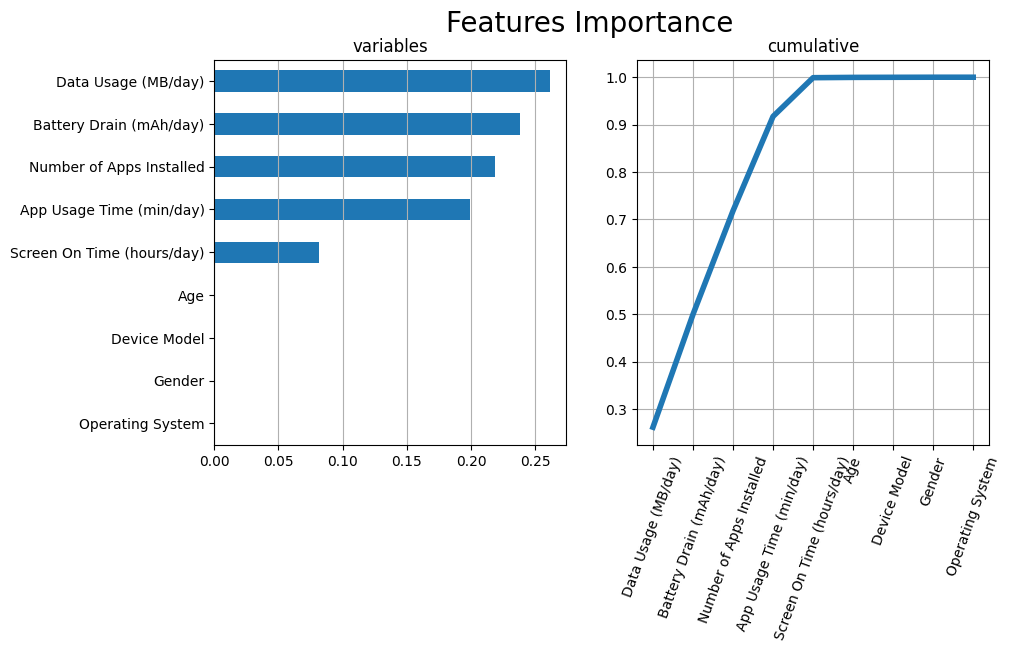

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100)# распаковываем  кортеж в переменные figи ax.
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')# подпишем график
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')# подпишем график
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')#Настроим линии сетки.
'''
Отрисовываем
'''
plt.show()

In [63]:
X_train_dropped = X_train[['Data Usage (MB/day)', 'Number of Apps Installed', 'Screen On Time (hours/day)']]

X_test_dropped = X_test[['Data Usage (MB/day)', 'Number of Apps Installed', 'Screen On Time (hours/day)']]